# Quiero andar en bicicleta

Si trabajasteis con el conjunto de datos de Bike Sharing con modelos lineales, probablemente notasteis la falta de linealidad en los datos y no quedasteis totalmente satisfechos con los
resultados. Ahora tenemos una nueva oportunidad para mejorar el modelo.
El conjunto de datos de Bike Sharing del repositorio de conjuntos de datos de UCI recopila estadísticas agregadas del uso de bicicletas con información adicional relevante. Podéis descargar los
datos desde aquí https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset.
El objetivo de este problema es predecir cuántas bicicletas se usarán diariamente (el archivo
day.csv). Podéis leer en el Readme.txt los detalles sobre las variables.

In [1]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.regressor import prediction_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from sklearn.svm import LinearSVC, SVC, SVR

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                     f1_score, make_scorer, accuracy_score, roc_auc_score

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier,RandomForestRegressor,GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.ensemble import StackingClassifier, VotingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import eli5
from dtreeviz.trees import dtreeviz

import warnings
from apafib import load_attrition

from sklearn.inspection import permutation_importance

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)
from sklearn.datasets import fetch_openml

In [2]:
def save_results(train, test, name, df):
    df.loc[name,'train score (R2)'] = train
    df.loc[name,'test score (R2)'] = test
    return df

results_df = pd.DataFrame()

**a) El primer paso es preprocesar y preparar los datos antes de ajustar cualquier modelo. Hay
algunas variables que no son útiles para el problema o que no tiene sentido usar. Eliminadlas del conjunto de datos. Dividid los datos en conjuntos de entrenamiento y test (60 %
/40 %). Tened en cuenta que los modelos basados en árboles de decisión no necesitan ninguna normalización de los datos.**

In [3]:
day_data = pd.read_csv("./day.csv", header=0)

day_data = day_data.rename(columns={'dteday':'fecha','season':'estación','yr':'año','mnth':'mes','holiday':'festivo','weekday':'dia_semana','workingday':'lectivo','weathersit':'tiempo','temp':'temperatura','atemp':'sensación_térmica','hum':'humedad','windspeed':'vel_viento','casual':'usuarios_casuales','registered':'usuarios_registrados','cnt':'usuarios_totales','':'',})
day_data.head()

,instant,fecha,estación,año,mes,festivo,dia_semana,lectivo,tiempo,temperatura,sensación_térmica,humedad,vel_viento,usuarios_casuales,usuarios_registrados,usuarios_totales
0,1,2011-01-01,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600


In [4]:
## Dropeamos las columnas que creemos que no son relevantes
day_data.drop(columns=['instant'], inplace=True)
day_data.drop(columns=['fecha'], inplace=True)

## Los que se pueden inferir de otros datos
day_data.drop(columns=['lectivo'], inplace=True) ## si no es festivo i dia entre 1-5 ->lectivo
day_data.drop(columns=['sensación_térmica'], inplace=True) ##derivada de la temp, el viento y la humedad

## Estas literalmente nos dan los usuarios totales
day_data.drop(columns=['usuarios_casuales'], inplace=True)
day_data.drop(columns=['usuarios_registrados'], inplace=True)

day_data.head()

,estación,año,mes,festivo,dia_semana,tiempo,temperatura,humedad,vel_viento,usuarios_totales
0,1,0,1,0,6,2,0.344,0.806,0.160,985
1,1,0,1,0,0,2,0.363,0.696,0.249,801
2,1,0,1,0,1,1,0.196,0.437,0.248,1349
3,1,0,1,0,2,1,0.200,0.590,0.160,1562
4,1,0,1,0,3,1,0.227,0.437,0.187,1600


In [5]:
day_data.isna().sum()
## Parece que no tenemos valores perdidos

estación            0
año                 0
mes                 0
festivo             0
dia_semana          0
tiempo              0
temperatura         0
humedad             0
vel_viento          0
usuarios_totales    0
dtype: int64

In [6]:
X = day_data.loc[:,day_data.columns != 'usuarios_totales']
y = day_data['usuarios_totales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

**b) Ajustad un árbol de regresión explorando sus hiperparámetros adecuadamente. Registrad
la puntuación de la validación cruzada para el mejor modelo y la calidad del modelo con
los datos del test. Representad el árbol del modelo final utilizando la librería viztree
e intentad explicar cómo el árbol toma las decisiones a partir de los atributos en la parte
superior del árbol. Representad las predicciones del árbol contra los valores reales. ¿Hay
algo raro en la gráfica?**

In [7]:
param = {'criterion':['poisson', 'squared_error', 'friedman_mse', 'absolute_error'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt =  DecisionTreeRegressor(random_state=0)
dt_bs =  BayesSearchCV(dt,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
dt_bs.fit(X_train, y_train);

In [8]:
show_html(pd.DataFrame(dt_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
31,"{'criterion': 'squared_error', 'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 10, 'splitter': 'best'}",0.776,1
34,"{'criterion': 'friedman_mse', 'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 10, 'splitter': 'best'}",0.776,1
27,"{'criterion': 'squared_error', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'splitter': 'best'}",0.772,3
29,"{'criterion': 'squared_error', 'max_depth': 6, 'max_leaf_nodes': 30, 'min_samples_leaf': 10, 'splitter': 'best'}",0.771,4
16,"{'criterion': 'poisson', 'max_depth': None, 'max_leaf_nodes': 30, 'min_samples_leaf': 10, 'splitter': 'best'}",0.770,5


In [9]:
prediction = dt_bs.best_estimator_.predict(X_test);
R_squared = r2_score(y_test,prediction)
results_df = save_results(0.776,R_squared,"DecisionTree", results_df)

In [10]:
viz = dtreeviz(dt_bs.best_estimator_, scale=1.5,
               x_data=X_train,
               y_data=y_train,
               target_name='usuarios_totales',
               feature_names=X_train.columns,
               title="Decision Tree - Baseline",
               orientation='LR')

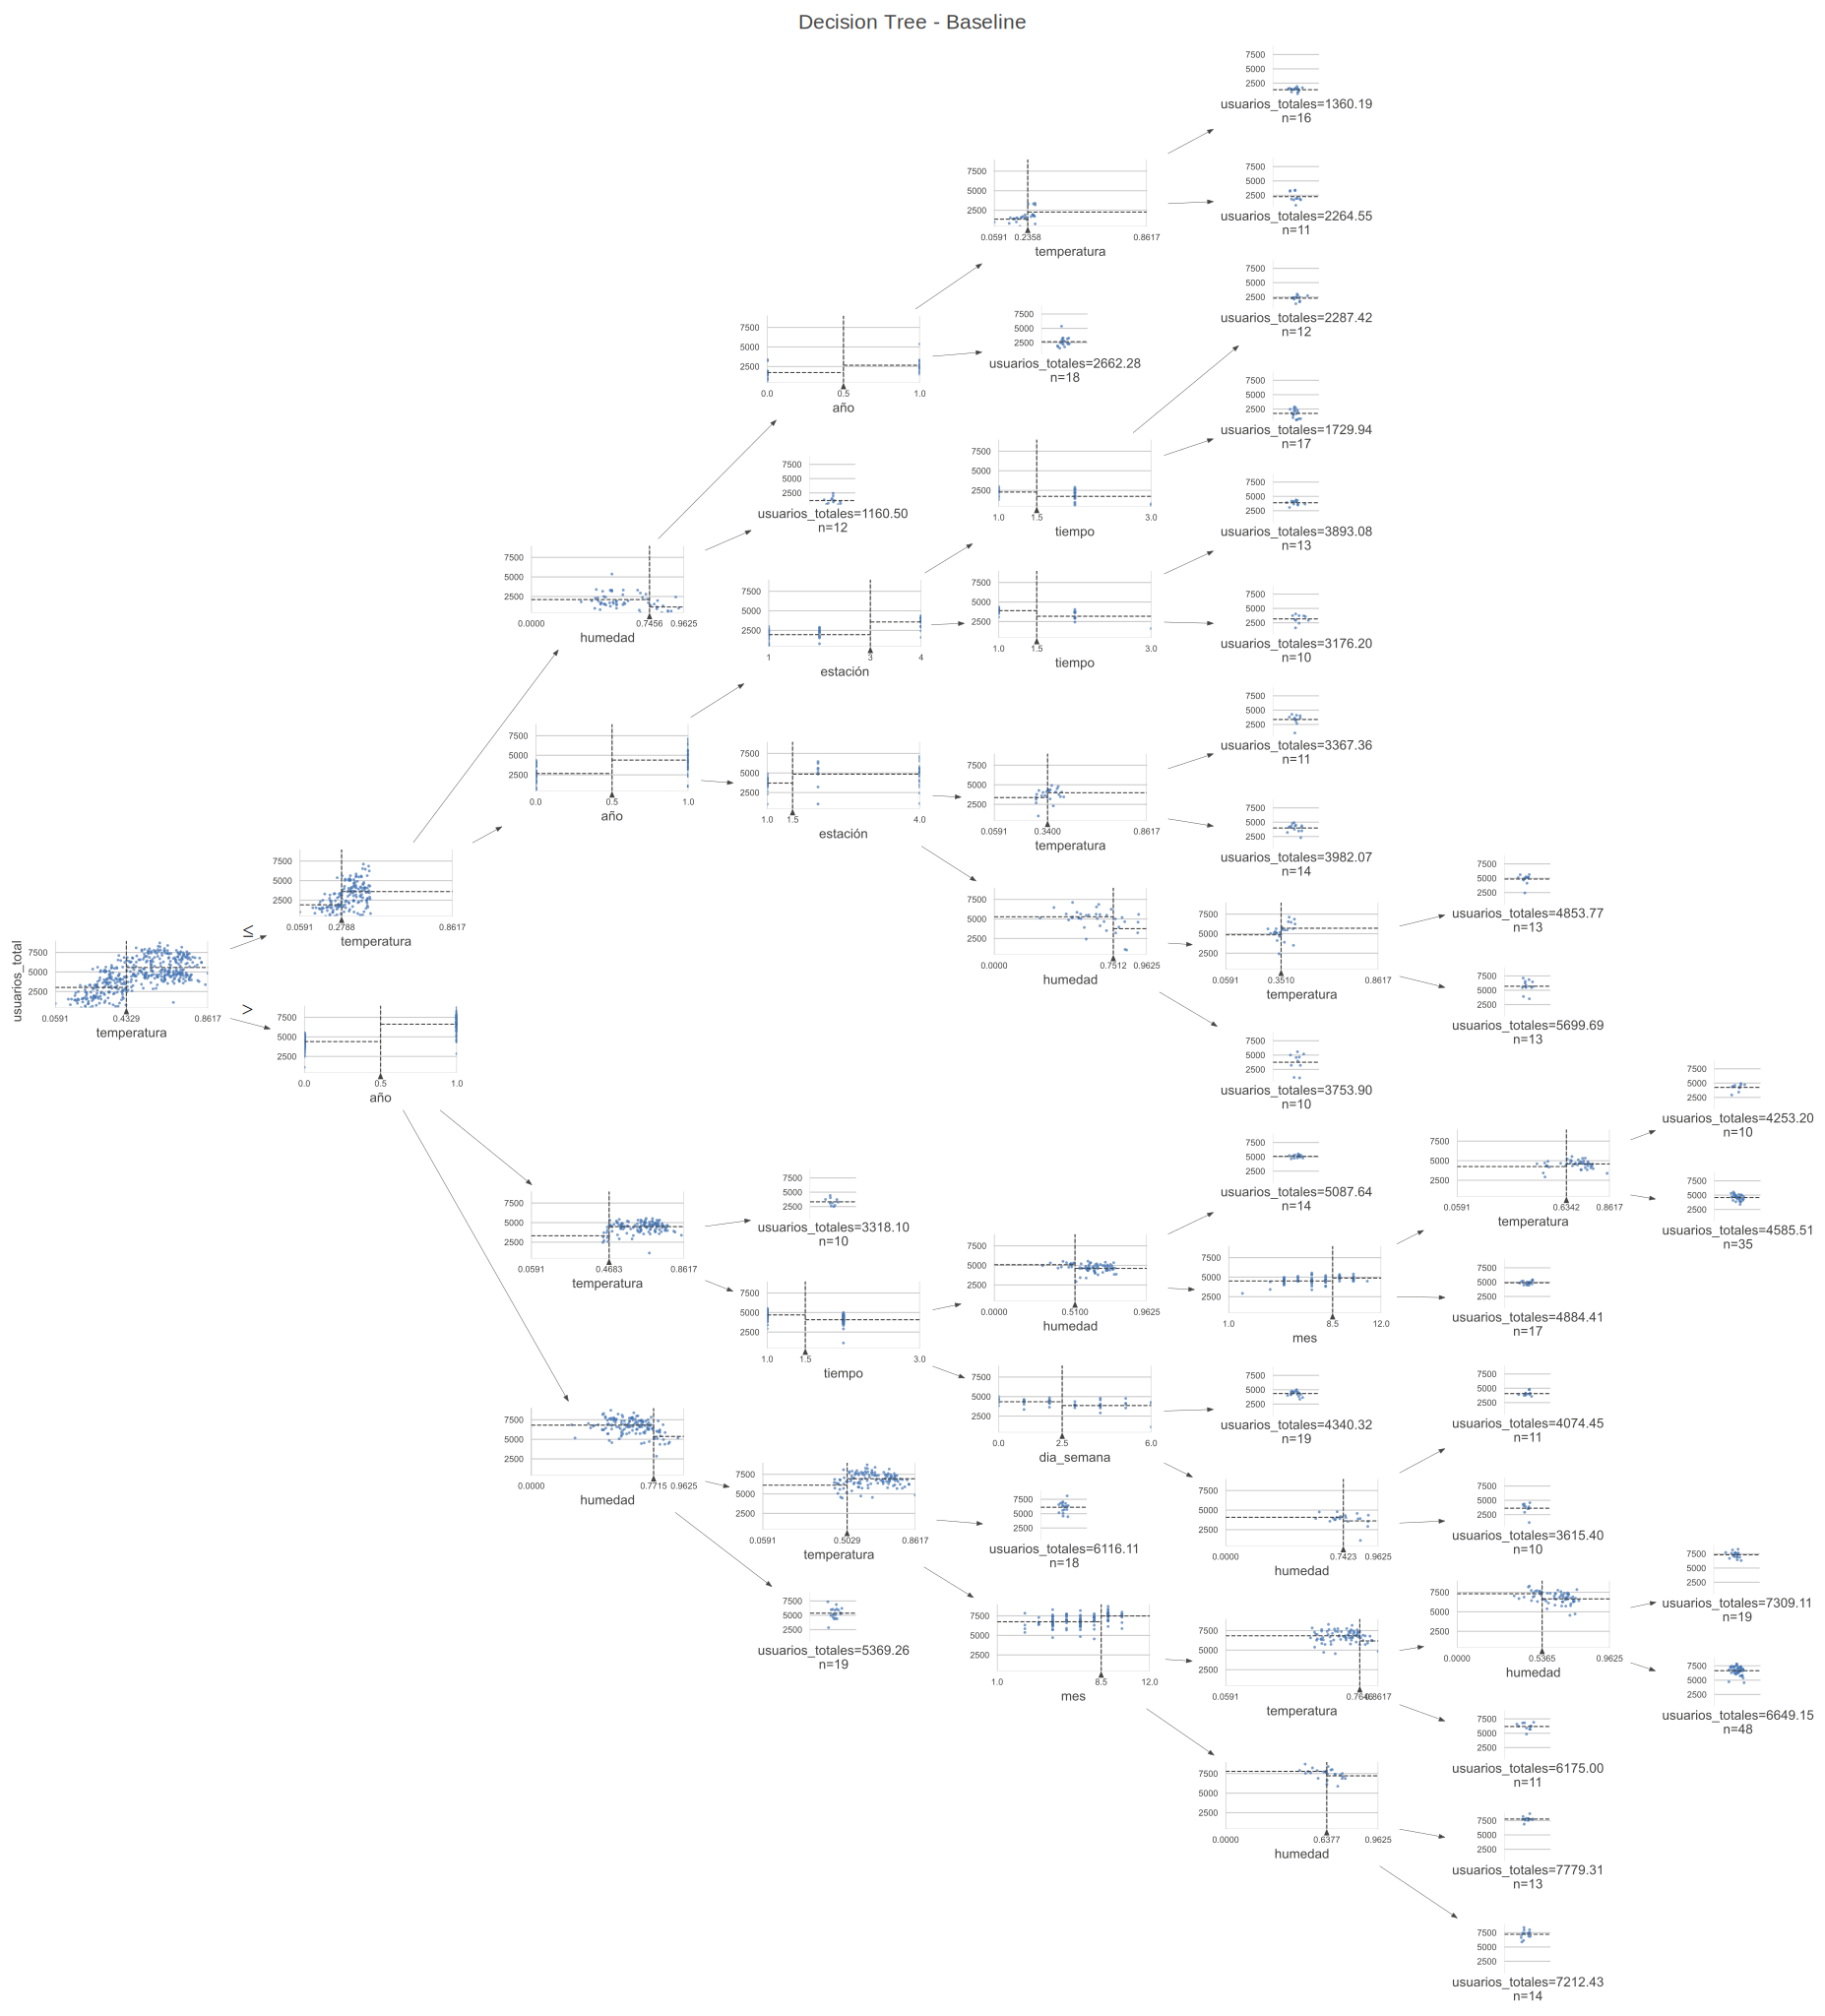

In [11]:
viz

* El árbol resultante es complejo, pero podemos ver a grandes rasgos como toma las decisiones. En primer lugar, utiliza la temperatura como primera pregunta para discriminar un menor número de usuarios (si la temperatura es baja) o un mayor número de usuarios si la temperatura es alta. Una vez hecho esta separación más general, se pregunta por el año, el tiempo, la estación, la humedad y la temperatura en distintos niveles del árbol, para ir distinguiendo un mayor o menor número de usuarios. Hay otros atributos relevantes a la decisión, pero los que más se repiten son los mencionados. Como línea general del proceso de decisiones del árbol, se intuye que en verano el número de usuarios es más alto que en estaciones más frías, como es natural en el tema que estamos tratando

<Figure size 800x800 with 0 Axes>

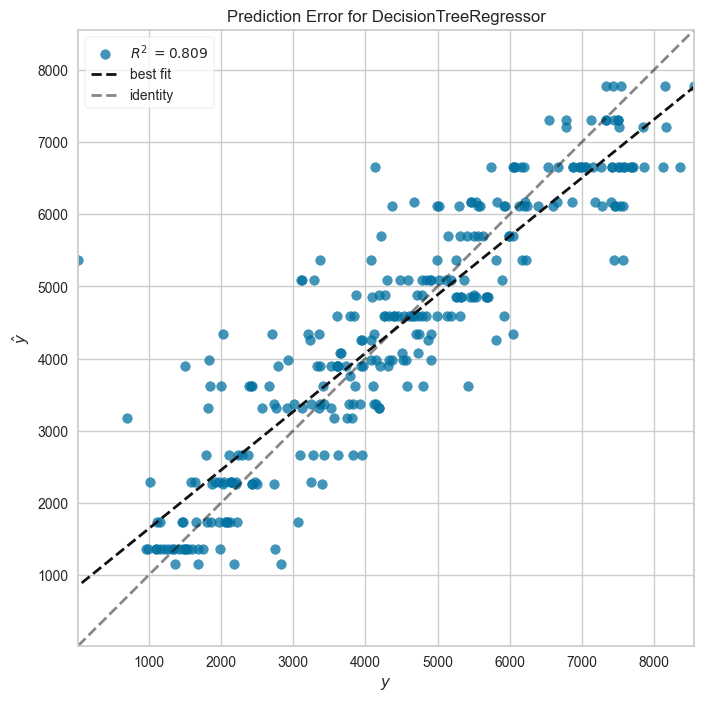

In [12]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(dt_bs.best_estimator_, X_test, y_test, is_fitted=True)

* Al representar las predicciones respecto a los valores reales vemos que ocurre algo extraño. Las predicciones se realizan en franjas marcadas, esto es así porque el árbol no tiene todos los valores posibles de usuarios en sus hojas. Si revisamos la representación gráfica comentada anteriormente, veremos que los valores posibles coinciden con las franjas que vemos en la comparación de los valores reales y las predicciones, ya que el árbol solo puede entregar como predicción alguno de los valores de sus hojas después de hacer las preguntas

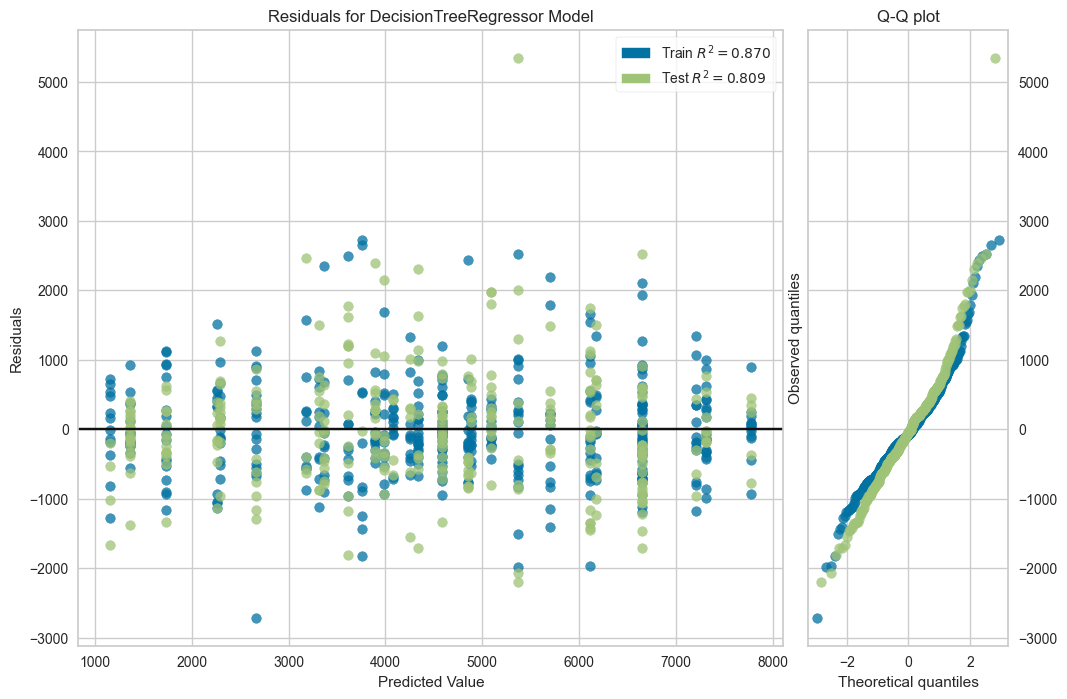

In [13]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(dt_bs.best_estimator_, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

**c) Ajustad un regresor de random forest y un regresor gradient boosting a los datos explorando sus hiperparámetros adecuadamente. Registrad la puntuación de la validación cruzada
para los mejores modelos y su calidad con los datos de test. ¿Son estos modelos mejores que el árbol de regresión? Calculad la relevancia de sus atributos utilizando la importancia
de permutación (permutation importance) con los datos de test. ¿Son los atributos relevantes de los modelos los que aparecen en los primeros niveles del árbol de regresión?
Representad sus predicciones contra los valores reales. ¿Ha desaparecido lo raro del gráfico anterior? ¿Por qué?**

In [14]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['friedman_mse', 'poisson', 'squared_error', 'absolute_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestRegressor(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train);

In [15]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'criterion': 'poisson', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.839,1
14,"{'criterion': 'poisson', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 10}",0.838,2
2,"{'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 10}",0.836,3
10,"{'criterion': 'friedman_mse', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 100}",0.836,4
3,"{'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 40}",0.832,5


In [16]:
prediction = rf_bs.best_estimator_.predict(X_test);
R_squared = r2_score(y_test,prediction)
results_df = save_results(0.839,R_squared,"RandomForest", results_df)

<Figure size 800x800 with 0 Axes>

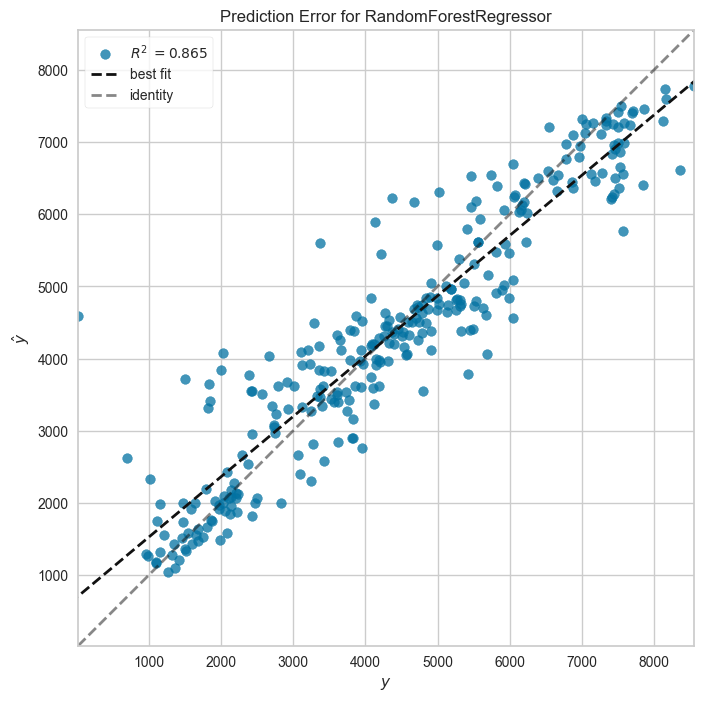

In [17]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(rf_bs.best_estimator_, X_test, y_test, is_fitted=True)

In [18]:
results_df.sort_values(by=['test score (R2)'], ascending=False)

,train score (R2),test score (R2)
RandomForest,0.839,0.865
DecisionTree,0.776,0.809


* Vemos como la calidad del modelo es superior a la del árbol de regresión tanto en el entrenamiento como en el test. Además, ha desaparecido la anomalía del apartado anterior, ya que RandomForest se conforma de la unión de diversos árboles de regresión, diluyendo esas franjas tan marcadas que veíamos antes. Esto mismo pasará con GradientBoosting, el modelo que entrenaremos a continuación

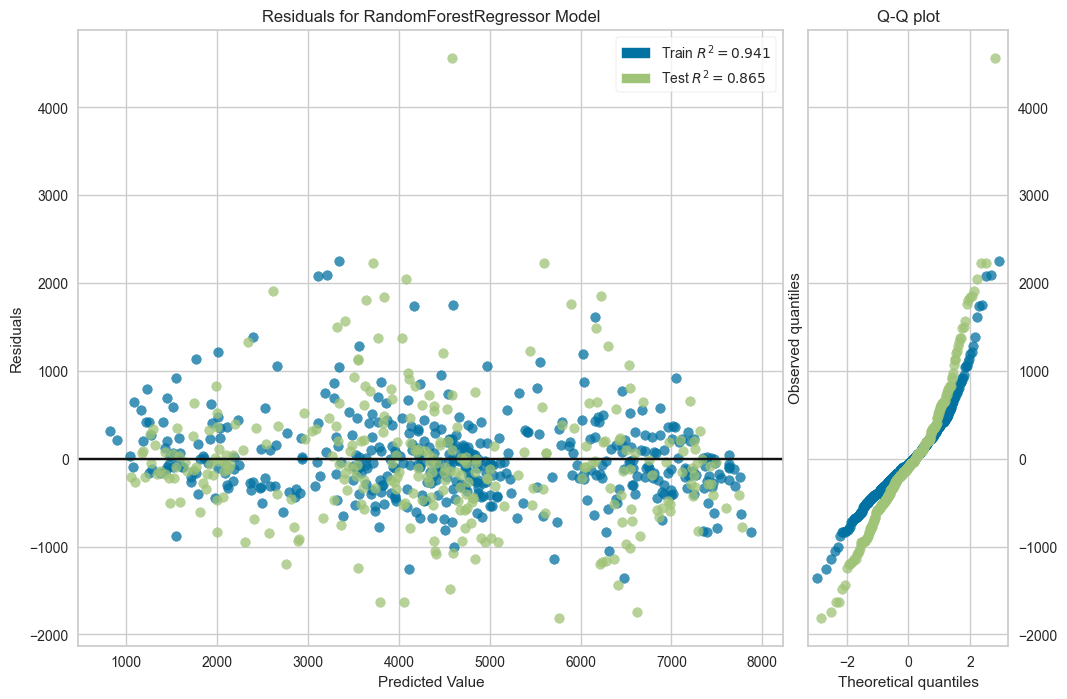

In [19]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(rf_bs.best_estimator_, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_bs.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.6633 ± 0.0990,temperatura
0.5204 ± 0.0792,año
0.0591 ± 0.0126,humedad
0.0479 ± 0.0089,estación
0.0241 ± 0.0062,mes
0.0196 ± 0.0104,vel_viento
0.0168 ± 0.0036,tiempo
0.0073 ± 0.0038,dia_semana
0.0001 ± 0.0003,festivo


* Los parámetros importantes obtenidos mediante "permutation_importance" son muy similares a la jerarquía vista en el árbol de regresión, la temperatura y el año se mantienen en los primeros puestos de igual manera que en el árbol de regresión. Aun así, aquí la velocidad del viento obtiene relevancia (mínima) cosa que no pasaba en el árbol de regresión

In [21]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['absolute_error', 'squared_error', 'huber', 'quantile'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingRegressor(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train);

In [22]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
19,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 40}",0.842,1
22,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 40}",0.842,1
23,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 40}",0.842,1
24,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 40}",0.842,1
25,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 40}",0.842,1


In [23]:
prediction = gb_bs.best_estimator_.predict(X_test);
R_squared = r2_score(y_test,prediction)
results_df = save_results(0.833,R_squared,"GradientBoosting", results_df)

<Figure size 800x800 with 0 Axes>

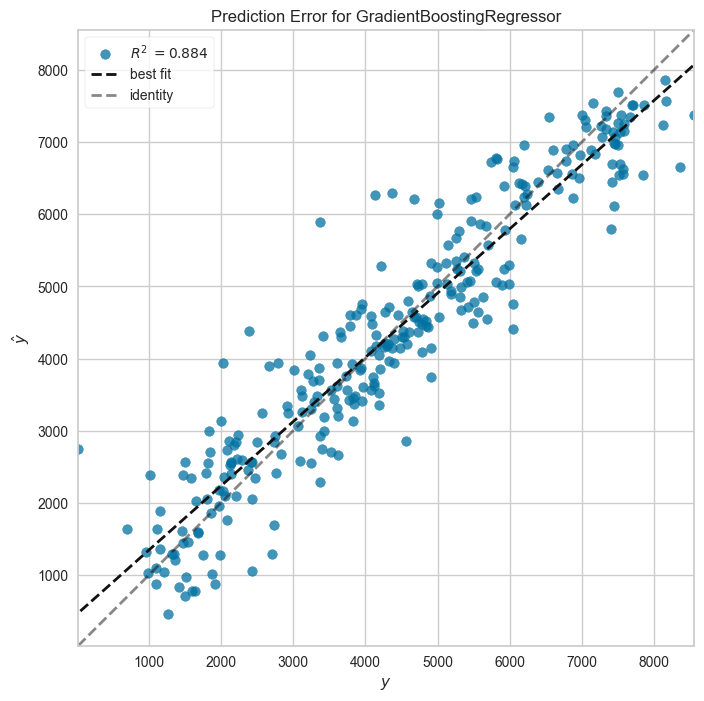

In [24]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(gb_bs.best_estimator_, X_test, y_test, is_fitted=True)

In [25]:
results_df.sort_values(by=['test score (R2)'], ascending=False)

,train score (R2),test score (R2)
GradientBoosting,0.833,0.884
RandomForest,0.839,0.865
DecisionTree,0.776,0.809


* Este modelo también es superior al árbol de regresión, aunque no es superior a RandomForest midiendo su acierto en entrenamiento y test. Como mencionábamos antes, aquí tampoco se produce la anomalía, por el mismo motivo que en RandomForest

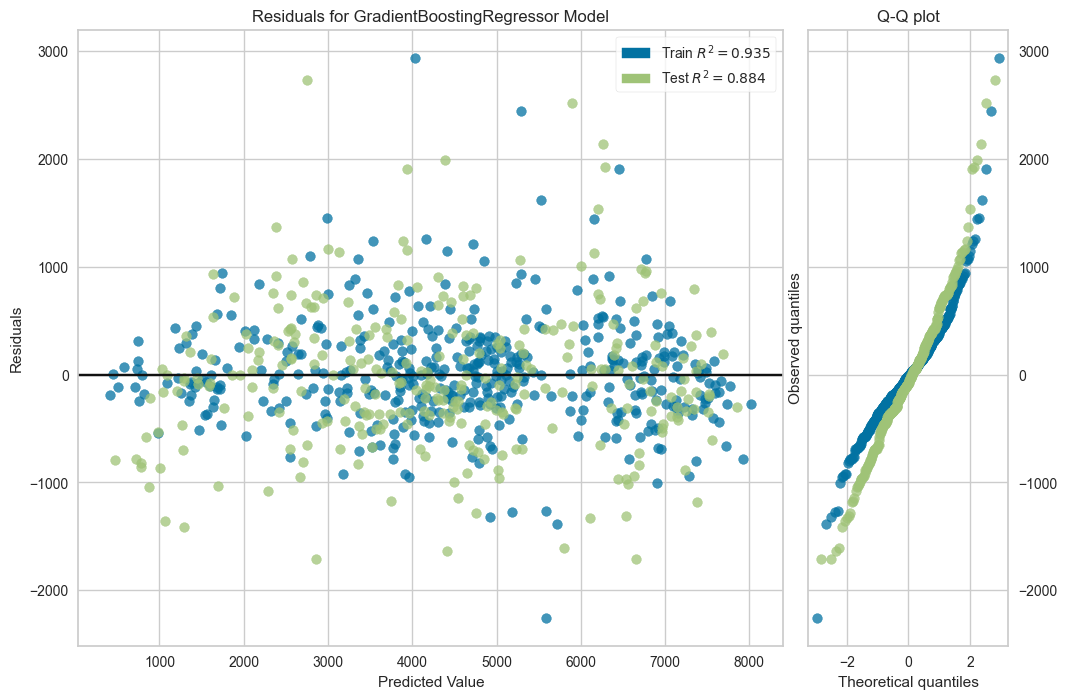

In [26]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(gb_bs.best_estimator_, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(gb_bs.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5276 ± 0.0875,año
0.4689 ± 0.0810,temperatura
0.1045 ± 0.0169,estación
0.0670 ± 0.0178,humedad
0.0561 ± 0.0118,tiempo
0.0466 ± 0.0241,vel_viento
0.0145 ± 0.0065,dia_semana
0.0111 ± 0.0037,mes
0.0074 ± 0.0074,festivo


* Los valores de importancia son prácticamente idénticos a los de RandomForest, así que se parecen bastante a la visualización del árbol de regresión que hemos comentado antes

**d) Ajustad una máquina de vectores de soporte para regresión usando un kernel RBF, normalizad adecuadamente los datos para este modelo. Explorad los hiperparámetros del modelo adecuadamente (observad que la SVM de regresión tiene los parámetros C y epsilon
además de los hiperparámetros específicos para el kernel). Registrad la puntuación de la
validación cruzada para el mejor modelo y su calidad con los datos del test. ¿Es mejor
este modelo? ¿Son diferentes las importancias de permutación? Considerando la calidad
de los modelos y el coste de computar las predicciones, ¿hay algún modelo que preferirías
utilizar en una aplicación que tiene que predecir en tiempo real? ¿Por qué?**

* Escalamos los datos para el modelo de SVM utilizando MinMaxScaler

In [28]:
mmscaler = MinMaxScaler()

X_train_m = mmscaler.fit_transform(X_train)
X_test_m = mmscaler.transform(X_test)

In [29]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto'], 'epsilon': np.linspace(0.1,10,101), 'shrinking':[True,False]}

rbsvc =  SVR(kernel='rbf', max_iter=50000, cache_size=2000)
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=40, cv=5, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs.fit(X_train_m, y_train);

In [30]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 660.6934480075951, 'epsilon': 2.4760000000000004, 'gamma': 'scale', 'shrinking': True}",0.813,1
14,"{'C': 660.6934480075951, 'epsilon': 4.357, 'gamma': 'scale', 'shrinking': False}",0.813,2
10,"{'C': 660.6934480075951, 'epsilon': 8.218, 'gamma': 'scale', 'shrinking': True}",0.813,3
39,"{'C': 501.18723362727246, 'epsilon': 9.406, 'gamma': 'scale', 'shrinking': True}",0.805,4
24,"{'C': 436.51583224016565, 'epsilon': 7.129, 'gamma': 'scale', 'shrinking': False}",0.800,5


In [31]:
prediction = rbsvc_gs.best_estimator_.predict(X_test_m);
R_squared = r2_score(y_test,prediction)
results_df = save_results(0.813,R_squared,"SVM_RBF", results_df)

<Figure size 800x800 with 0 Axes>

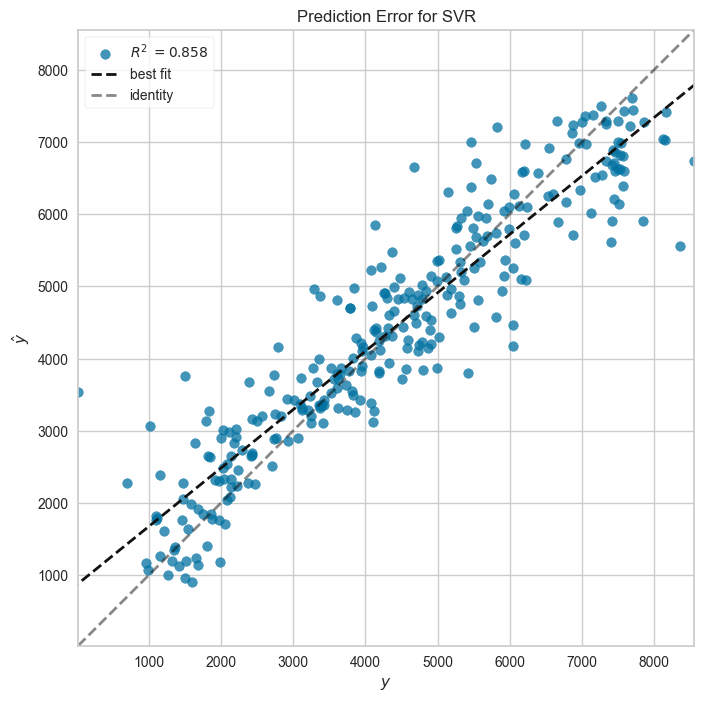

In [32]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(rbsvc_gs.best_estimator_, X_test_m, y_test, is_fitted=True)

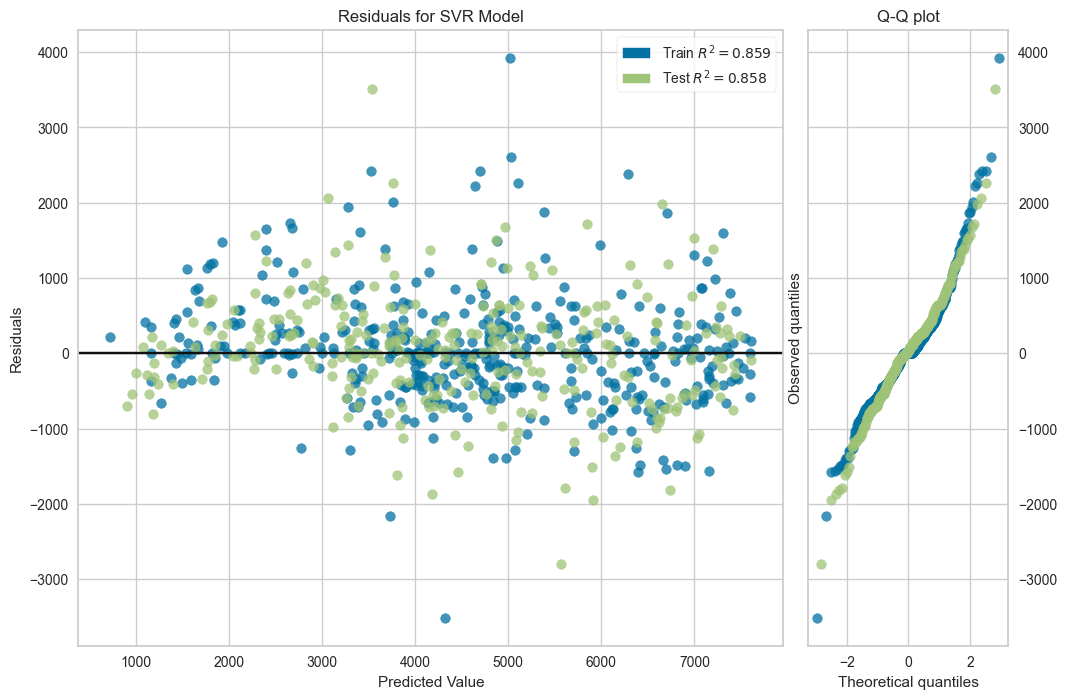

In [33]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(rbsvc_gs.best_estimator_, X_train_m, y_train, X_test_m, y_test, is_fitted=True, qqplot=True, hist=False);

In [34]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rbsvc_gs.best_estimator_, random_state=1).fit(X_test_m, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5459 ± 0.0811,año
0.2299 ± 0.0372,temperatura
0.1211 ± 0.0253,estación
0.0795 ± 0.0145,tiempo
0.0480 ± 0.0153,mes
0.0211 ± 0.0090,vel_viento
0.0122 ± 0.0049,dia_semana
0.0117 ± 0.0064,humedad
0.0043 ± 0.0050,festivo


* Los pesos son similares; sin embargo, "año" supera a "temperatura", cosa que no pasaba en los otros modelos. Hay algún otro cambio, como que la humedad pierde bastante relevancia en comparación con los otros modelos. En términos generales, la distribución de pesos se mantiene similar a los modelos de árboles de regresión

In [35]:
results_df.sort_values(by=['test score (R2)'], ascending=False)

,train score (R2),test score (R2)
GradientBoosting,0.833,0.884
RandomForest,0.839,0.865
SVM_RBF,0.813,0.858
DecisionTree,0.776,0.809


* En cuanto a la calidad del modelo, es superior a la del árbol de regresión y mínimamente superior a GradientBoosting. Podríamos decir que el resultado de los tres modelos mejor posicionados es muy similar, así que en caso de tener que computar predicciones en tiempo real, descartaríamos el modelo de SVM, ya que aplica el kernel a cada par de entradas, lo cual hace que escale muy mal en tiempo de cómputo si llegamos a tamaños muy grandes. Sin embargo, RandomForest (el modelo con el mejor resultado en este caso) utiliza árboles de regresión independientes. Construir cada árbol es computacionalmente barato, además de que pueden ser creados en paralelo. En resumen, RandomForest es un modelo que escala mejor temporalmente que SVM, así que sería más indicado para una aplicación en tiempo real que necesita de esa inmediatez

In [36]:
results_df.head()

,train score (R2),test score (R2)
DecisionTree,0.776,0.809
RandomForest,0.839,0.865
GradientBoosting,0.833,0.884
SVM_RBF,0.813,0.858
